# MPST: Movie Plot Synopses with Tags

## 1. Business Problem

### 1.1 Sources and Refernces: 

Data Source : https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags#mpst_full_data.csv

Research paper : https://www.aclweb.org/anthology/L18-1274

Research paper : http://ritual.uh.edu/mpst-2018/

### 1.2 Business Constraints:

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience.
3. No strict latency constraints.

## 2. Machine Learning Problem:

Contains all the IMDB id, title, plot synopsis, tags for the movies. There are 14,828 movies' data in total. The split column indicates where the data instance resides in the Train/Dev/Test split.

Columns
imdb_id

IMDB id of the movie
title:- Title of the move

plot_synopsis:- Plot Synopsis of the move

tags:- Tags assigned to the move

split:-Position of the movie in the standard data split

synopsis_source:-From where the plot synopsis was collected

# 3. Exploratory Data Analysis:

## 3.1 Data Loading and Cleaning

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [1]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 4.3MB/s 


In [0]:
data = pd.read_csv('mpst_full_data.csv')
data.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'tags', 'split',
       'synopsis_source'],
      dtype='object')

In [0]:
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [0]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 50000
    j=0
    index_start = 1
    for df in pd.read_csv('mpst_full_data.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [0]:
# Counting number of rows

if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Run the above cell to genarate train.db file")
    
    

Number of rows in the database : 
 14828
Time taken to count the number of rows : 0:00:00


### Number of train, test and validation data:

In [0]:
con = sqlite3.connect('train.db') 
no_dup = pd.read_sql_query('SELECT split, COUNT(*) AS num FROM data GROUP BY split', con)
con.close()

In [0]:
no_dup

,split,num
0,test,2966
1,train,9489
2,val,2373


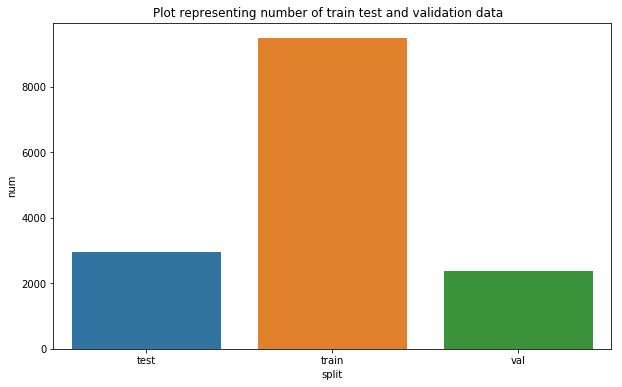

In [0]:
plt.figure(figsize=(10, 6))
plt.title ("Plot representing number of train test and validation data  ")
sns.barplot(no_dup['split'],no_dup['num'])
plt.show()

### Data Sources:

In [0]:
con = sqlite3.connect('train.db') 
no_dup = pd.read_sql_query('SELECT synopsis_source, COUNT(*) AS num FROM data GROUP BY synopsis_source', con)
con.close()

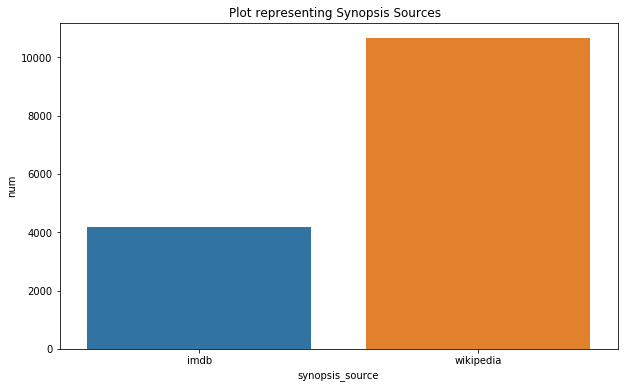

In [0]:
plt.figure(figsize=(10, 6))
plt.title ("Plot representing Synopsis Sources  ")
sns.barplot(no_dup['synopsis_source'],no_dup['num'])
plt.show()

### 3.1.2 Checking for duplicates 

In [0]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, plot_synopsis, Tags, split, COUNT(*) as cnt_dup FROM data GROUP BY title, plot_synopsis, tags, split', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Run the first to genarate train.db file")

Time taken to run this cell : 0:00:00.546881


In [0]:
df_no_dup.head()

,title,plot_synopsis,tags,split,cnt_dup
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,1
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,1
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,1
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,1
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,1


In [0]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 47 ( 0.3169678985702751 % )


In [0]:
# number of times each movie appeared in our database
df_no_dup.cnt_dup.value_counts()

1    14743
2       32
3        4
5        1
4        1
Name: cnt_dup, dtype: int64

In [0]:
# number of tags per movie title.
df_no_dup["tag_count"] = df_no_dup['tags'].apply(lambda text: len(text.split(",")))
df_no_dup.head()

,title,plot_synopsis,tags,split,cnt_dup,tag_count
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,1,1
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,1,1
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,1,4
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,1,2
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,1,6


In [0]:
df_no_dup.tag_count.value_counts()

1     5478
2     3115
3     1959
4     1238
5      916
6      606
7      478
8      316
9      223
10     135
11     107
13      52
12      51
14      33
15      28
16      16
18      11
17       9
21       3
23       2
20       2
19       2
25       1
Name: tag_count, dtype: int64

In [0]:
# database with no duplicates

if not os.path.isfile("train_no_dup.db"):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns = ['title', 'plot_synopsis', 'tags', 'split'])
    no_dup.to_sql('no_dup_train', disk_dup)

In [0]:
# loading again
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Run the above cells to genarate train_no_dup.db file")

Time taken to run this cell : 0:00:00.125001


# 3.2 Analysis of Tags

## 3.2.1 Total number of unique tags 

In [0]:
# using count vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))

tag_dtm = vectorizer.fit_transform(tag_data['tags'])

In [0]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 14780
Number of unique tags : 142


In [0]:
# some of the tags
tags = vectorizer.get_feature_names()

print("Some of the tags we have :", tags[:10])

Some of the tags we have : [' absurd', ' action', ' adult comedy', ' allegory', ' alternate history', ' alternate reality', ' anti war', ' atmospheric', ' autobiographical', ' avant garde']


### 3.2.3 Number of times a tag appeared 

In [0]:
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [0]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,absurd,178
1,action,599
2,adult comedy,110
3,allegory,82
4,alternate history,79


In [0]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

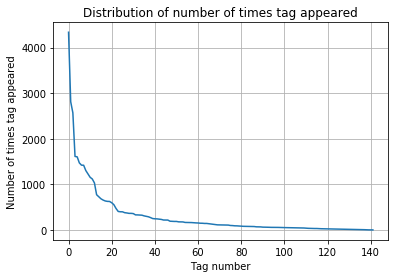

In [0]:
plt.plot(tag_counts[:1000])
plt.title("Distribution of number of times tag appeared")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

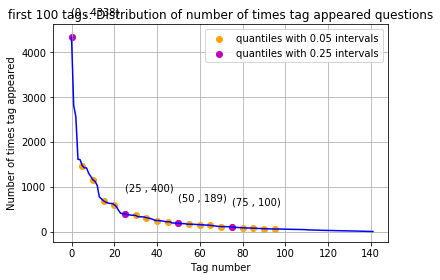

20 [4338 1473 1157  686  599  400  361  311  247  219  189  165  155  139
  113  100   84   78   64   59]


In [0]:
plt.plot(tag_counts, c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

### 3.2.4 Tags Per Question

In [0]:
# Storing the count of tag in each question in the list 'tag_count
tag_quest_count = tag_dtm.sum(axis=1).tolist()

# converting list of lists into single list,we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 14780 datapoints.
[1, 4, 2, 6, 1]


In [0]:
print ("Maximum no of tag per question: %d"%max(tag_quest_count))
print ("Minimum no of tags per quest: %d"%min(tag_quest_count))
print ("Avg number of tags per qudestion: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum no of tag per question: 25
Minimum no of tags per quest: 1
Avg number of tags per qudestion: 2.987077


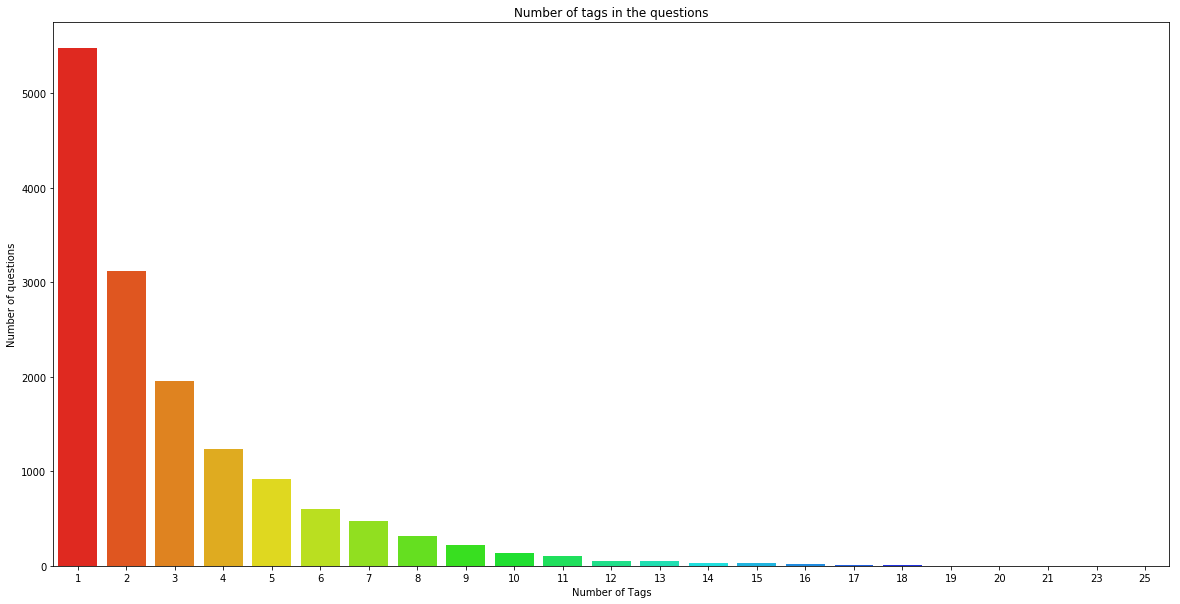

In [0]:
fig = plt.figure(figsize=(20,10))
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 1
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.99

### 3.2.5 Most Frequent Tags 

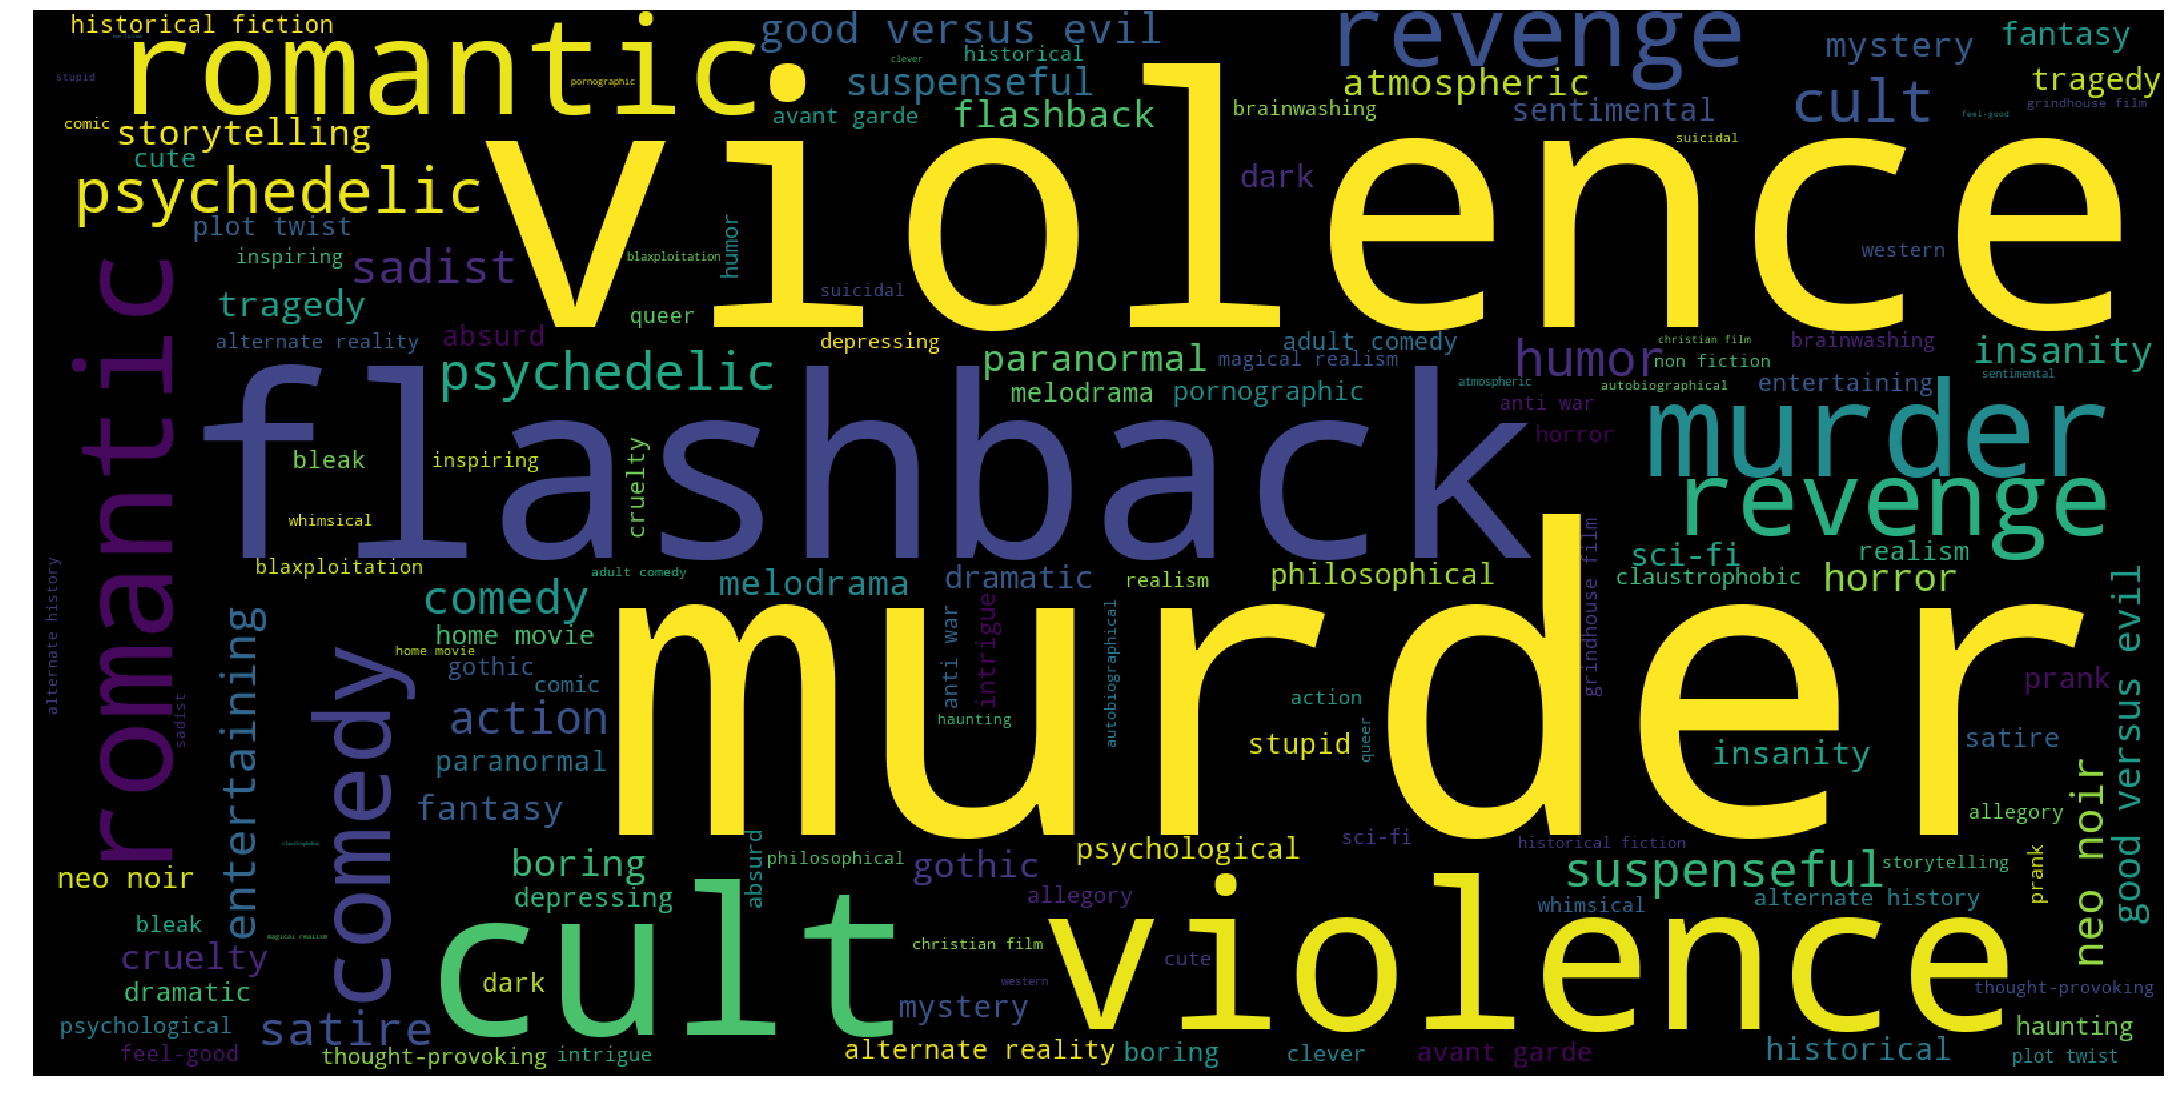

Time taken to run this cell : 0:00:04.417730


In [0]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "violence", "murder", "flashback", "romantic", "cult" are some of the most frequent tags.

### 3.2.6 The top 20 tags

<Figure size 1440x720 with 0 Axes>

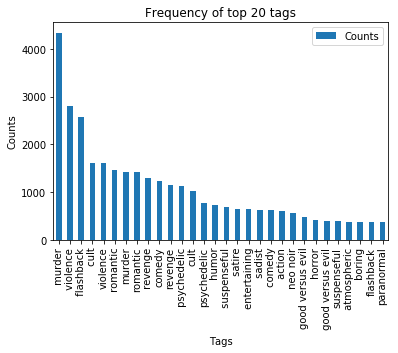

In [0]:
i=np.arange(30)
fig = plt.figure(figsize=(20,10))
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

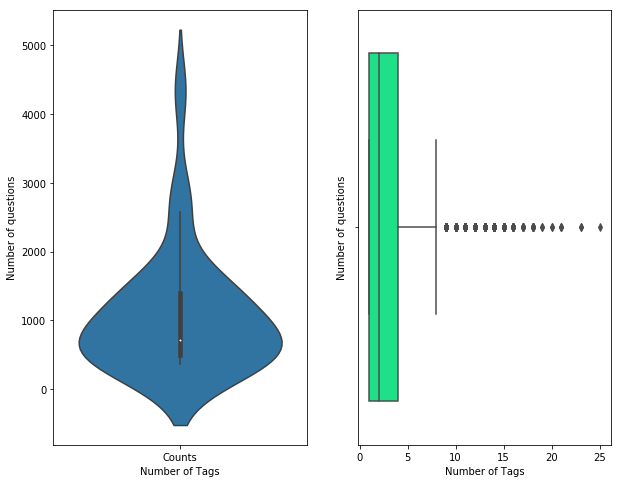

In [0]:
# Obsetving the quantiles using the violin plot and box .

plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(data = tag_df_sorted.head(30) , )
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")

plt.subplot(1,2,2)
sns.boxplot(tag_quest_count, palette='gist_rainbow')
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Observation: Most of the tags are acquired by 800 questions and has 1 tags. 

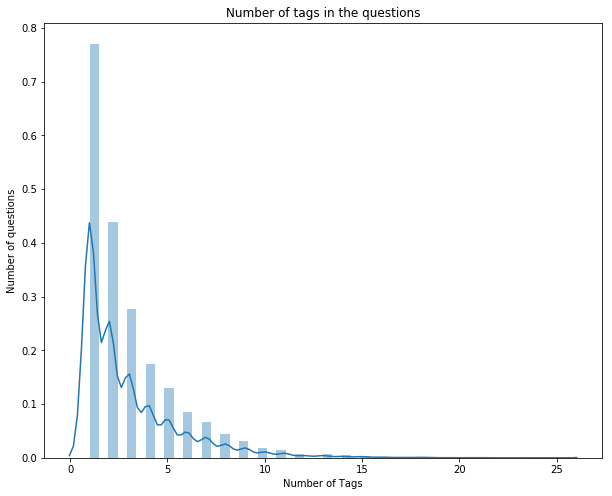

In [0]:
# plot for average no of tags per question 

plt.figure(figsize=(10, 8))
plt.subplot()
sns.distplot(tag_quest_count)
plt.title("Number of tags in the questions")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Observation: Most of the questions have 1 tags in average and there is an average of 450 questions with 1 tags, 250 questions with 2 tag and so on.

## 3.3 Cleaning and preprocessing of Questions

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    my_data = pd.read_sql_query("""SELECT * FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    my_data.drop(my_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    my_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Run the above cells to genarate train_no_dup.db file")

Time taken to run this cell : 0:00:01.500045


In [0]:
# printing some random reviews
sent_0 = my_data['plot_synopsis'].values[0]
print(sent_0)
print("="*50)

sent_1000 = my_data['plot_synopsis'].values[1000]
print(sent_1000)
print("="*50)

A 6th grader named Griffin Bing decides to gather their entire grade in a sleepover protest in an old house about to be demolished after their plan for using a new space in their town was thrown out because of their youth. However, only Griffin and his best friend Ben Slovak show up. Griffin discovers a Babe Ruth baseball card that, unbeknownst to him, is worth huge amounts of money. Excited that the card could help his family, which is struggling financially, Griffin takes it to the local collectibles dealer, S. Wendell Palomino. S. Wendell tells the boys that the card is an old counterfeit of a valuable one, worth only one hundred dollars. A dejected Griffin later chances upon Palomino on television, stating that the card he stole was worth at least a million dollars. Enraged, Griffin and Ben try to steal it back from Swindle's shop, only to find that it has gone, and they have to break into Swindle's house. Now, in order to get the card back, Griffin must gather a team of local stud

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)

print(sent_0)

A 6th grader named Griffin Bing decides to gather their entire grade in a sleepover protest in an old house about to be demolished after their plan for using a new space in their town was thrown out because of their youth. However, only Griffin and his best friend Ben Slovak show up. Griffin discovers a Babe Ruth baseball card that, unbeknownst to him, is worth huge amounts of money. Excited that the card could help his family, which is struggling financially, Griffin takes it to the local collectibles dealer, S. Wendell Palomino. S. Wendell tells the boys that the card is an old counterfeit of a valuable one, worth only one hundred dollars. A dejected Griffin later chances upon Palomino on television, stating that the card he stole was worth at least a million dollars. Enraged, Griffin and Ben try to steal it back from Swindle's shop, only to find that it has gone, and they have to break into Swindle's house. Now, in order to get the card back, Griffin must gather a team of local stud

In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

A 6th grader named Griffin Bing decides to gather their entire grade in a sleepover protest in an old house about to be demolished after their plan for using a new space in their town was thrown out because of their youth. However, only Griffin and his best friend Ben Slovak show up. Griffin discovers a Babe Ruth baseball card that, unbeknownst to him, is worth huge amounts of money. Excited that the card could help his family, which is struggling financially, Griffin takes it to the local collectibles dealer, S. Wendell Palomino. S. Wendell tells the boys that the card is an old counterfeit of a valuable one, worth only one hundred dollars. A dejected Griffin later chances upon Palomino on television, stating that the card he stole was worth at least a million dollars. Enraged, Griffin and Ben try to steal it back from Swindle's shop, only to find that it has gone, and they have to break into Swindle's house. Now, in order to get the card back, Griffin must gather a team of local stud

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(my_data['plot_synopsis'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 14780/14780 [00:35<00:00, 415.57it/s]


In [0]:
preprocessed_reviews[1500]

'william nessen american freelance journalist travels aceh indonesia cover conflict taking place time shot period four years black road follows nessen transforms objective journalist supporter free aceh movement gerakan aceh merdeka gam tsunami made aceh indonesian province northern tip sumatra well known across world people remain ignorant struggle independence william nessen first travelled aceh print journalist point nessen no plans film recorded footage intended sell television networks began visit general bambang darmono leader indonesian military aceh gaining trust general darmono nessen able obtain information shooting opportunities would unavailable journalists period fell love trusted military translator sya diah syeh marhaban spy separatist movement worked together continuing extract sensitive information general darmono nessen collection footage grew thought making film idea would later evolve black road nessen marhaban married aceh days wedding nessen best man human rights 

In [0]:
my_data['preprocessed_data'] = preprocessed_reviews

In [0]:
import pickle
my_data.to_pickle("final_data")

In [0]:
new_data = pd.read_pickle("final_data")

In [0]:
new_data.head()

,index,title,plot_synopsis,tags,split,preprocessed_data
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,grader named griffin bing decides gather entir...
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,gary hook new recruit british army takes leave...
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,sergeant dragon jackie chan part hong kong mar...
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,pretoria south africa major charles bolton rod...
5,5,'C'-Man,Customs Investigator Cliff Holden (Dean Jagger...,murder,train,customs investigator cliff holden dean jagger ...


<h1>4. Machine Learning Models </h1>

<h2>4.1 Split the data into test and train </h2>

In [0]:
x_train=new_data.loc[(new_data['split'] == 'train') | (new_data['split'] == 'val')]
x_test=new_data.loc[(new_data['split'] == 'test')]

#### Analysing Tags one more time:

In [0]:
import nltk
all_genres = nltk.FreqDist(new_data['tags'].apply(lambda x: x.split(',')[0]))
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

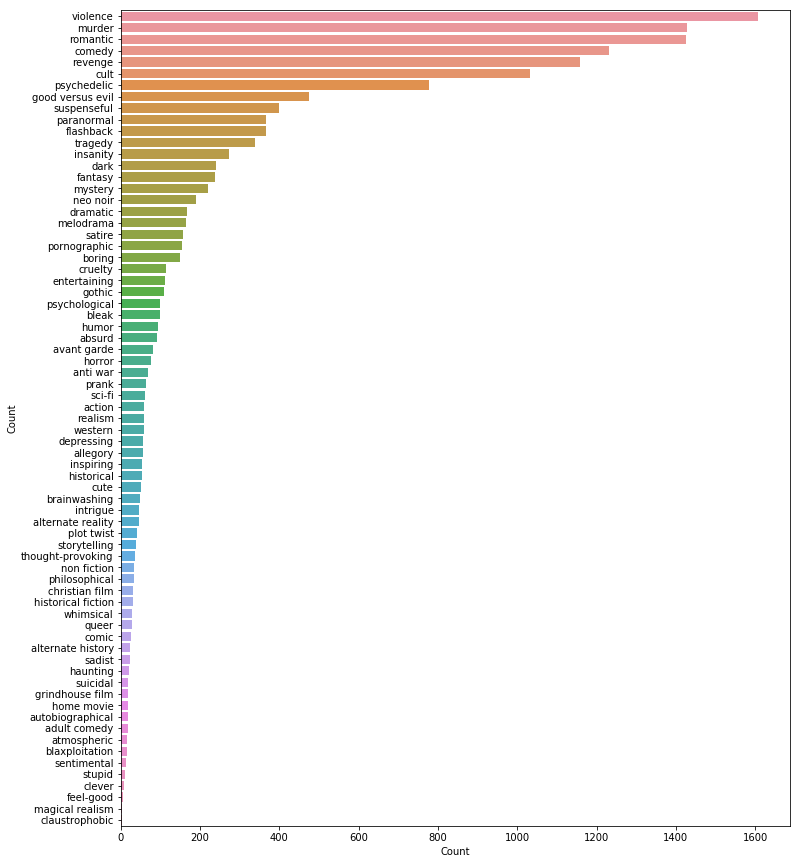

In [0]:
g = all_genres_df.nlargest(columns="Count", n = 100) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

<h6>OBSERVATION:</h6> The number of tags are completely unbalanced.

<h2>4.3 Featurizing data </h2>

### Pipeline and One Vs Rest classifier:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

X_train = np.array(x_train['preprocessed_data'])
Y_train = np.array(x_train['tags'])
X_test = np.array(x_test['preprocessed_data'])
Y_test = np.array(x_test['tags'])

model = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', class_weight="balanced"), n_jobs=-1))
                      ])
model.fit(X_train, Y_train)

In [0]:
from sklearn.externals import joblib
joblib.dump(model, "pipeline1.pkl", compress=9)
""" Predict the test dataset using Naive Bayes"""
prediction = model.predict(X_test)

In [0]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy : 0.005398110661268556
Hamming loss  0.05500038014863812
Micro-average quality numbers
Precision: 0.1586, Recall: 0.3639, F1-measure: 0.2209
Macro-average quality numbers
Precision: 0.0733, Recall: 0.1752, F1-measure: 0.0969
             precision    recall  f1-score   support

          0       0.07      0.09      0.08        35
          1       0.14      0.42      0.21       117
          2       0.10      0.12      0.11        26
          3       0.07      0.18      0.10        11
          4       0.14      0.38      0.20        13
          5       0.04      0.08      0.05        26
          6       0.03      0.07      0.04        15
          7       0.07      0.17      0.10        75
          8       0.00      0.00      0.00         4
          9       0.04      0.03      0.04        31
         10       0.03      0.12      0.05         8
         11       0.04      0.05      0.05        20
         12       0.09      0.15      0.11        79
         13       0.03 

### Applying Logistic Regression with OneVsRest Classifier

In [0]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=50000, tokenizer = lambda x: x.split())
vectorizer.fit(x_train['preprocessed_data'])
x_train_multilabel = vectorizer.transform(x_train['preprocessed_data'])
x_test_multilabel = vectorizer.transform(x_test['preprocessed_data'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:09.106299


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (11816, 50000) Y : (11816, 142)
Dimensions of test data X: (2964, 50000) Y: (2964, 142)


In [0]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
start = datetime.now()
model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', class_weight="balanced"))

parameters = {
    "estimator__alpha": [10**-5,10**-4,  10**-3, 10**-1, 10**1]
}
model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabel, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.10172648121582308
{'estimator__alpha': 1e-05}
Time taken to run this cell : 0:05:36.648090


In [0]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)-

Accuracy : 0.0006747638326585695
Hamming loss  0.12262644694075384
Micro-average quality numbers
Precision: 0.0678, Recall: 0.3704, F1-measure: 0.1146
Macro-average quality numbers
Precision: 0.0471, Recall: 0.3029, F1-measure: 0.0717
             precision    recall  f1-score   support

          0       0.02      0.20      0.03        35
          1       0.12      0.36      0.18       117
          2       0.03      0.54      0.06        26
          3       0.01      0.27      0.01        11
          4       0.02      0.62      0.04        13
          5       0.02      0.23      0.03        26
          6       0.02      0.47      0.04        15
          7       0.04      0.23      0.07        75
          8       0.00      0.25      0.01         4
          9       0.03      0.23      0.05        31
         10       0.02      0.62      0.03         8
         11       0.00      0.05      0.01        20
         12       0.04      0.29      0.08        79
         13       0.01

In [0]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(LogisticRegression(C=0.00001, class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.0
Hamming loss  0.1783134705669917
Micro-average quality numbers
Precision: 0.0807, Recall: 0.7040, F1-measure: 0.1447
Macro-average quality numbers
Precision: 0.0484, Recall: 0.4170, F1-measure: 0.0796
             precision    recall  f1-score   support

          0       0.02      0.40      0.04        35
          1       0.07      0.94      0.14       117
          2       0.05      0.58      0.09        26
          3       0.01      0.18      0.01        11
          4       0.03      0.77      0.05        13
          5       0.03      0.65      0.06        26
          6       0.04      0.60      0.07        15
          7       0.04      0.83      0.07        75
          8       0.01      0.25      0.03         4
          9       0.02      0.29      0.04        31
         10       0.04      0.50      0.08         8
         11       0.01      0.30      0.02        20
         12       0.03      0.91      0.06        79
         13       0.01      0.33      0.0

### Linear SVM :- 

In [0]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()
model_to_set = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))

parameters = {
    "estimator__alpha": [10**-5, 10**-3, 10**-2, 10**1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabel, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.17046158034897937
{'estimator__alpha': 1e-05}
Time taken to run this cell : 0:10:13.612452


In [0]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.0
Hamming loss  0.12170696242230712
Micro-average quality numbers
Precision: 0.0656, Recall: 0.3532, F1-measure: 0.1106
Macro-average quality numbers
Precision: 0.0480, Recall: 0.3006, F1-measure: 0.0724
             precision    recall  f1-score   support

          0       0.02      0.23      0.04        35
          1       0.11      0.38      0.17       117
          2       0.04      0.46      0.08        26
          3       0.01      0.18      0.01        11
          4       0.02      0.69      0.04        13
          5       0.02      0.31      0.05        26
          6       0.02      0.47      0.04        15
          7       0.03      0.15      0.05        75
          8       0.00      0.25      0.01         4
          9       0.02      0.19      0.04        31
         10       0.02      0.62      0.05         8
         11       0.01      0.15      0.02        20
         12       0.05      0.35      0.09        79
         13       0.01      0.56      0.

 ## Featurizing data with TfIdf vectorizer 

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=50000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['preprocessed_data'])
x_test_multilabel = vectorizer.transform(x_test['preprocessed_data'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:30.167028


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (11816, 50000) Y : (11816, 142)
Dimensions of test data X: (2964, 50000) Y: (2964, 142)


<h3> Applying Logistic Regression with OneVsRest Classifier </h3>

In [0]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))

parameters = {
    "estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabel, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.15835410206450806
{'estimator__alpha': 1e-05}
Time taken to run this cell : 0:01:34.344331


In [0]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.005398110661268556
Hamming loss  0.05500038014863812
Micro-average quality numbers
Precision: 0.1586, Recall: 0.3639, F1-measure: 0.2209
Macro-average quality numbers
Precision: 0.0733, Recall: 0.1752, F1-measure: 0.0969
             precision    recall  f1-score   support

          0       0.07      0.09      0.08        35
          1       0.14      0.42      0.21       117
          2       0.10      0.12      0.11        26
          3       0.07      0.18      0.10        11
          4       0.14      0.38      0.20        13
          5       0.04      0.08      0.05        26
          6       0.03      0.07      0.04        15
          7       0.07      0.17      0.10        75
          8       0.00      0.00      0.00         4
          9       0.04      0.03      0.04        31
         10       0.03      0.12      0.05         8
         11       0.04      0.05      0.05        20
         12       0.09      0.15      0.11        79
         13       0.03 

### Linear SVM :- 

In [0]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()
model_to_set = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))

parameters = {
    "estimator__alpha": [10**-5, 10**-3, 10**-2, 10**1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabel, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.15155415487444512
{'estimator__alpha': 1e-05}
Time taken to run this cell : 0:09:01.232018


In [0]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.0023616734143049934
Hamming loss  0.0660840888787516
Micro-average quality numbers
Precision: 0.1254, Recall: 0.3488, F1-measure: 0.1845
Macro-average quality numbers
Precision: 0.0641, Recall: 0.2168, F1-measure: 0.0883
             precision    recall  f1-score   support

          0       0.05      0.09      0.06        35
          1       0.17      0.35      0.23       117
          2       0.03      0.12      0.05        26
          3       0.04      0.18      0.07        11
          4       0.08      0.54      0.15        13
          5       0.02      0.08      0.03        26
          6       0.03      0.40      0.05        15
          7       0.06      0.24      0.10        75
          8       0.00      0.00      0.00         4
          9       0.03      0.03      0.03        31
         10       0.03      0.38      0.06         8
         11       0.03      0.05      0.04        20
         12       0.09      0.22      0.12        79
         13       0.02 

<h3>Performance of baseline Models:</h3>

In [0]:
from prettytable import PrettyTable
ptable = PrettyTable()

ptable.title = " Comparison of Performances "
ptable.field_names = ['Model','Hyperparameter', 'Precession','Recall','F1-Score']
ptable.add_row(["Logistic Regression (BOW)","0.00001","0.19", "0.18", '0.19'])
ptable.add_row(["Linear SVM (BOW)", "0.00001", "0.18", "0.17", '0.18'])
ptable.add_row(["Logistic Regression (Tfidf)", "0.00001", "0.26", "0.11", '0.15'])
ptable.add_row(["Linear SVM (Tfidf)", "0.00001", "0.22", "0.14", '0.16'])

print(ptable)

+-----------------------------+----------------+------------+--------+----------+
|            Model            | Hyperparameter | Precession | Recall | F1-Score |
+-----------------------------+----------------+------------+--------+----------+
|  Logistic Regression (BOW)  |    0.00001     |    0.19    |  0.18  |   0.19   |
|       Linear SVM (BOW)      |    0.00001     |    0.18    |  0.17  |   0.18   |
| Logistic Regression (Tfidf) |    0.00001     |    0.26    |  0.11  |   0.15   |
|      Linear SVM (Tfidf)     |    0.00001     |    0.22    |  0.14  |   0.16   |
+-----------------------------+----------------+------------+--------+----------+


##### Model not performing well so considering more feature engineering

## Feature Engineering:

In [3]:
# Code to read csv file into Colaboratory from google drive:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.4MB/s 


In [0]:
final = 'https://drive.google.com/open?id=15aSHHI7Fys2OuSoZGe3iPpOgEpOKGfRj'

In [5]:
fluff, id5 = final.split('=')

print (id5)

15aSHHI7Fys2OuSoZGe3iPpOgEpOKGfRj


In [0]:
downloaded5 = drive.CreateFile({'id':id5}) 
downloaded5.GetContentFile('final_data')

In [0]:
new_data = pd.read_pickle("final_data")

In [0]:
X = new_data['preprocessed_data']
y = new_data['tags']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

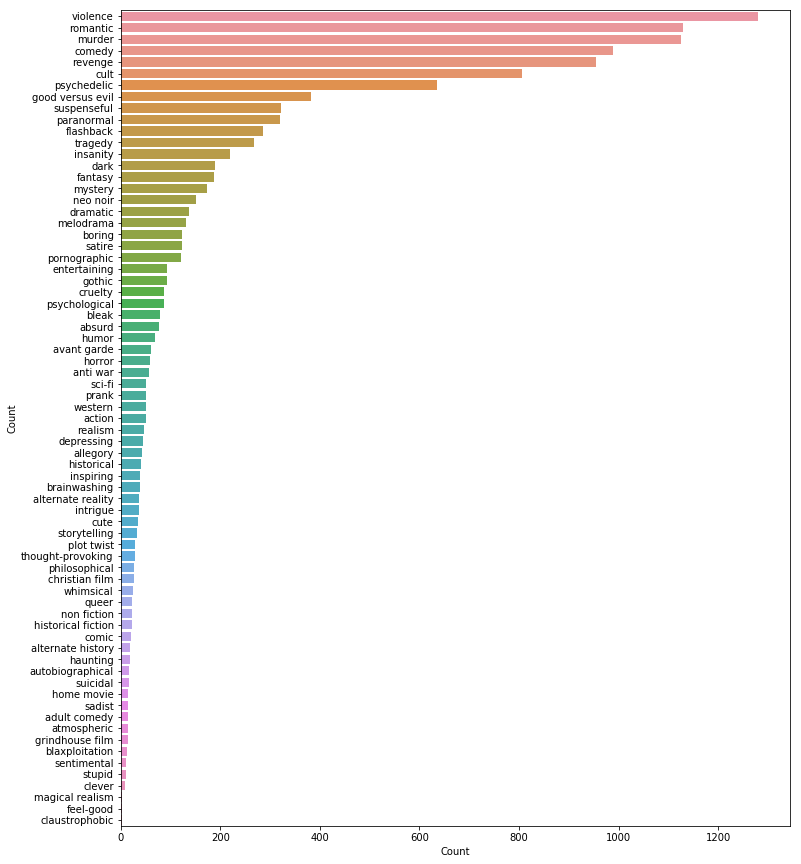

In [15]:
# checking the uniformity of the tags

import nltk
all_genres = nltk.FreqDist(y_train.apply(lambda x: x.split(',')[0]))
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

g = all_genres_df.nlargest(columns="Count", n = 100) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

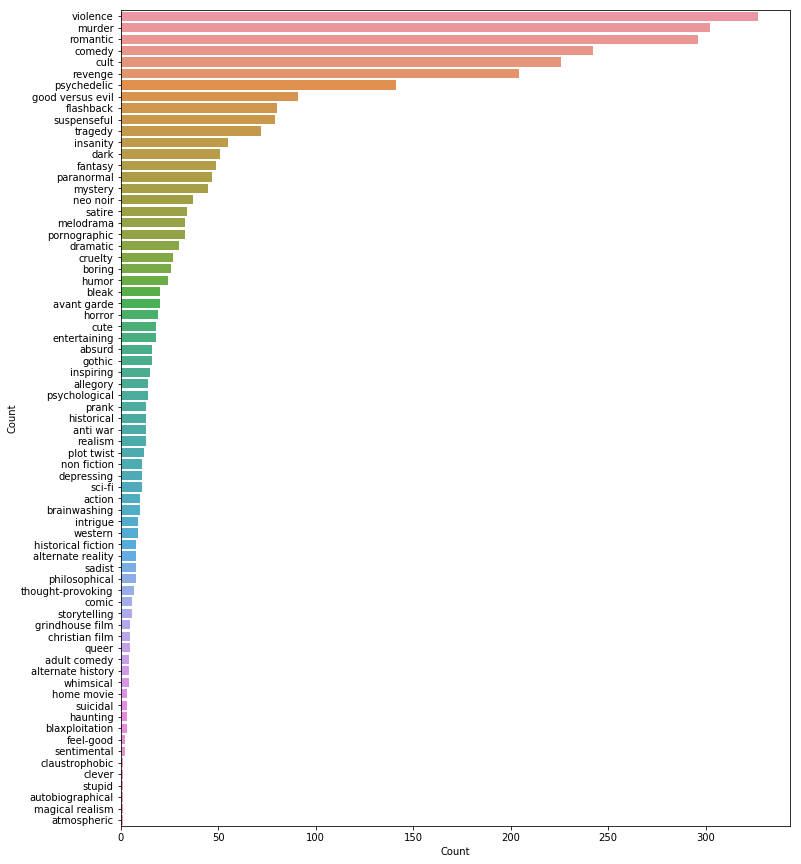

In [16]:
import nltk
all_genres = nltk.FreqDist(y_test.apply(lambda x: x.split(',')[0]))
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})
g = all_genres_df.nlargest(columns="Count", n = 100) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

Since the number of tags are completely unbalanced and few of them are not of that importance. So we would try to reduce the number of tags by analysing them.

### Converting tags for multilabel problems 

<b> We have seen above that the distribution of tags per synopsis isn't uniform. Some of the synopsis have >20 tags wheras some have 1 tag. But the in an average the number of tags per synopsis is 2.9 (see EDA). So we would consider 4 tags per plot synopsis. </b>

In [0]:
## Analysing tags

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true', max_features = 4)
multilabel_y_train = vectorizer.fit_transform(y_train)
multilabel_y_test = vectorizer.transform(y_test)

### Unigram

In [49]:
# unigram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,1))
x_train_multilabe_uni = vectorizer.fit_transform(X_train)
x_test_multilabel_uni = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:03.874541


In [62]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabe_uni, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.4297968028569633
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:03.524394


In [63]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabe_uni, multilabel_y_train)
predictions = classifier.predict (x_test_multilabel_uni)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.3318673883626522
Hamming loss  0.30294316644113667
Micro-average quality numbers
Precision: 0.3311, Recall: 0.6079, F1-measure: 0.4287
Macro-average quality numbers
Precision: 0.3223, Recall: 0.5954, F1-measure: 0.4118
              precision    recall  f1-score   support

           0       0.20      0.54      0.29       308
           1       0.25      0.53      0.34       507
           2       0.48      0.64      0.55       844
           3       0.36      0.68      0.47       552

   micro avg       0.33      0.61      0.43      2211
   macro avg       0.32      0.60      0.41      2211
weighted avg       0.36      0.61      0.44      2211
 samples avg       0.19      0.26      0.20      2211

Time taken to run this cell : 0:00:00.391169


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Bigram:

In [52]:
# bigram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(2,2))
x_train_multilabe_bi = vectorizer.fit_transform(X_train)
x_test_multilabel_bi = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:31.653510


In [53]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabe_bi, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.40495992259001856
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:01.122359


In [67]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabe_bi, multilabel_y_train)
predictions = classifier.predict (x_test_multilabel_bi)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.37516914749661706
Hamming loss  0.2790933694181326
Micro-average quality numbers
Precision: 0.3450, Recall: 0.5482, F1-measure: 0.4235
Macro-average quality numbers
Precision: 0.3304, Recall: 0.5309, F1-measure: 0.4038
              precision    recall  f1-score   support

           0       0.21      0.46      0.29       308
           1       0.28      0.48      0.35       507
           2       0.46      0.59      0.52       844
           3       0.37      0.59      0.46       552

   micro avg       0.35      0.55      0.42      2211
   macro avg       0.33      0.53      0.40      2211
weighted avg       0.36      0.55      0.43      2211
 samples avg       0.17      0.23      0.18      2211

Time taken to run this cell : 0:00:00.104916


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Trigram:

In [65]:
# trigram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(3,3))
x_train_multilabe_tri = vectorizer.fit_transform(X_train)
x_test_multilabel_tri = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:43.848315


In [66]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabe_tri, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.320370968053034
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:00.389017


In [68]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabe_tri, multilabel_y_train)
predictions = classifier.predict (x_test_multilabel_tri)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2774018944519621
Hamming loss  0.35597090663058184
Micro-average quality numbers
Precision: 0.2381, Recall: 0.4107, F1-measure: 0.3014
Macro-average quality numbers
Precision: 0.2354, Recall: 0.4053, F1-measure: 0.2911
              precision    recall  f1-score   support

           0       0.13      0.37      0.19       308
           1       0.21      0.43      0.28       507
           2       0.35      0.42      0.38       844
           3       0.25      0.40      0.31       552

   micro avg       0.24      0.41      0.30      2211
   macro avg       0.24      0.41      0.29      2211
weighted avg       0.26      0.41      0.31      2211
 samples avg       0.14      0.18      0.14      2211

Time taken to run this cell : 0:00:00.062588


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### ngram:

In [69]:
# 1 to 3 gram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_1 = vectorizer.fit_transform(X_train)
x_test_1 = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:25.980471


In [75]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_1, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.43537498842312106
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:04.791252


In [76]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_1, multilabel_y_train)
predictions = classifier.predict (x_test_1)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.33558863328822736
Hamming loss  0.2987144790257104
Micro-average quality numbers
Precision: 0.3353, Recall: 0.6083, F1-measure: 0.4323
Macro-average quality numbers
Precision: 0.3264, Recall: 0.5954, F1-measure: 0.4155
              precision    recall  f1-score   support

           0       0.20      0.54      0.29       308
           1       0.26      0.54      0.35       507
           2       0.48      0.64      0.55       844
           3       0.36      0.66      0.47       552

   micro avg       0.34      0.61      0.43      2211
   macro avg       0.33      0.60      0.42      2211
weighted avg       0.36      0.61      0.45      2211
 samples avg       0.19      0.26      0.20      2211

Time taken to run this cell : 0:00:00.389888


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Unigram + bigram + ngram:


In [0]:
# combining features
from scipy.sparse import coo_matrix, hstack
train_1 = hstack((x_train_multilabe_uni, x_train_multilabe_bi),format="csr",dtype='float64')
test_1 = hstack((x_test_multilabel_uni, x_test_multilabel_bi),format="csr",dtype='float64')

In [0]:
train_2 = hstack((train_1, x_train_1),format="csr",dtype='float64')
test_2 = hstack((test_1, x_test_1),format="csr",dtype='float64')

In [84]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(train_2, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.44795244711069937
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:11.382344


In [88]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(train_2, multilabel_y_train)
predictions = classifier.predict (test_2)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.3623139377537212
Hamming loss  0.2834066305818674
Micro-average quality numbers
Precision: 0.3509, Recall: 0.6065, F1-measure: 0.4446
Macro-average quality numbers
Precision: 0.3358, Recall: 0.5894, F1-measure: 0.4232
              precision    recall  f1-score   support

           0       0.21      0.55      0.30       308
           1       0.28      0.47      0.35       507
           2       0.48      0.67      0.56       844
           3       0.38      0.68      0.48       552

   micro avg       0.35      0.61      0.44      2211
   macro avg       0.34      0.59      0.42      2211
weighted avg       0.37      0.61      0.46      2211
 samples avg       0.20      0.26      0.21      2211

Time taken to run this cell : 0:00:00.922825


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Char 3-gram:

In [89]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(3, 3),  max_features=20000)
x_train_3char = vectorizer.fit_transform(X_train)
x_test_3char = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:23.299955


In [90]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_3char, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.46544995286032065
{'estimator__alpha': 0.0001}
Time taken to run this cell : 0:00:15.799001


In [94]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_3char, multilabel_y_train)
predictions = classifier.predict (x_test_3char)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.3457374830852503
Hamming loss  0.2873815967523681
Micro-average quality numbers
Precision: 0.3567, Recall: 0.6680, F1-measure: 0.4651
Macro-average quality numbers
Precision: 0.3408, Recall: 0.6407, F1-measure: 0.4418
              precision    recall  f1-score   support

           0       0.22      0.52      0.31       308
           1       0.28      0.62      0.38       507
           2       0.49      0.74      0.59       844
           3       0.38      0.68      0.49       552

   micro avg       0.36      0.67      0.47      2211
   macro avg       0.34      0.64      0.44      2211
weighted avg       0.37      0.67      0.48      2211
 samples avg       0.21      0.28      0.23      2211

Time taken to run this cell : 0:00:01.148391


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Char 4-gram:


In [95]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(4, 4),  max_features=20000)
x_train_4char = vectorizer.fit_transform(X_train)
x_test_4char = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:38.516180


In [96]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_4char, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.476084480394257
{'estimator__alpha': 0.0001}
Time taken to run this cell : 0:00:26.063463


In [104]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_4char, multilabel_y_train)
predictions = classifier.predict (x_test_4char)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.38836265223274696
Hamming loss  0.25431326116373476
Micro-average quality numbers
Precision: 0.3917, Recall: 0.6508, F1-measure: 0.4890
Macro-average quality numbers
Precision: 0.3674, Recall: 0.6100, F1-measure: 0.4583
              precision    recall  f1-score   support

           0       0.28      0.44      0.34       308
           1       0.31      0.56      0.40       507
           2       0.48      0.77      0.59       844
           3       0.40      0.68      0.50       552

   micro avg       0.39      0.65      0.49      2211
   macro avg       0.37      0.61      0.46      2211
weighted avg       0.39      0.65      0.49      2211
 samples avg       0.22      0.28      0.23      2211

Time taken to run this cell : 0:00:01.852960


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Char (3-6gram) :

In [105]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(3, 6),  max_features=20000)
x_train_36char = vectorizer.fit_transform(X_train)
x_test_36char = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:27.433399


In [106]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_36char, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

0.47566124329486026
{'estimator__alpha': 0.0001}
Time taken to run this cell : 0:00:56.720863


In [111]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_36char, multilabel_y_train)
predictions = classifier.predict (x_test_36char)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.34100135317997293
Hamming loss  0.2922868741542625
Micro-average quality numbers
Precision: 0.3557, Recall: 0.6943, F1-measure: 0.4704
Macro-average quality numbers
Precision: 0.3471, Recall: 0.6839, F1-measure: 0.4528
              precision    recall  f1-score   support

           0       0.20      0.70      0.32       308
           1       0.30      0.58      0.40       507
           2       0.49      0.76      0.60       844
           3       0.39      0.70      0.50       552

   micro avg       0.36      0.69      0.47      2211
   macro avg       0.35      0.68      0.45      2211
weighted avg       0.38      0.69      0.49      2211
 samples avg       0.21      0.29      0.23      2211

Time taken to run this cell : 0:00:03.987050


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Char 3gram + Char 4gram:

In [0]:
# combining features
from scipy.sparse import coo_matrix, hstack
train_10 = hstack((x_train_3char, x_train_4char),format="csr",dtype='float64')
test_10 = hstack((x_test_3char, x_test_4char),format="csr",dtype='float64')

In [0]:
train_11 = hstack((train_10, x_train_36char),format="csr",dtype='float64')
test_11 = hstack((test_10, x_test_36char),format="csr",dtype='float64')

In [118]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(train_11, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.4674353453301887
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:01:37.283418


In [127]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(train_11, multilabel_y_train)
predictions = classifier.predict (test_11)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.35182679296346414
Hamming loss  0.2868741542625169
Micro-average quality numbers
Precision: 0.3598, Recall: 0.6852, F1-measure: 0.4718
Macro-average quality numbers
Precision: 0.3514, Recall: 0.6693, F1-measure: 0.4551
              precision    recall  f1-score   support

           0       0.24      0.60      0.34       308
           1       0.27      0.68      0.39       507
           2       0.49      0.73      0.59       844
           3       0.41      0.67      0.51       552

   micro avg       0.36      0.69      0.47      2211
   macro avg       0.35      0.67      0.46      2211
weighted avg       0.38      0.69      0.49      2211
 samples avg       0.22      0.29      0.23      2211

Time taken to run this cell : 0:00:07.139096


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### Combining all:

In [0]:
train_20 = hstack((train_11, train_2),format="csr",dtype='float64')
test_20 = hstack((test_11, test_2),format="csr",dtype='float64')

In [137]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(train_20, multilabel_y_train)
predictions = classifier.predict (test_20)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.36028416779431666
Hamming loss  0.2807848443843031
Micro-average quality numbers
Precision: 0.3648, Recall: 0.6766, F1-measure: 0.4740
Macro-average quality numbers
Precision: 0.3501, Recall: 0.6596, F1-measure: 0.4528
              precision    recall  f1-score   support

           0       0.23      0.63      0.33       308
           1       0.30      0.56      0.39       507
           2       0.49      0.75      0.59       844
           3       0.38      0.71      0.50       552

   micro avg       0.36      0.68      0.47      2211
   macro avg       0.35      0.66      0.45      2211
weighted avg       0.38      0.68      0.49      2211
 samples avg       0.21      0.29      0.23      2211

Time taken to run this cell : 0:00:08.722892


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# Models with 3 tags:

<b> We have seen above that the distribution of tags per synopsis isn't uniform. Some of the synopsis have >20 tags wheras some have 1 tag. But the in an average the number of tags per synopsis is 2.9 (see EDA). So now we would consider 3 tags per plot synopsis. </b>

In [0]:
## Analysing tags

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true', max_features = 3)
multilabel_y_train = vectorizer.fit_transform(y_train)
multilabel_y_test = vectorizer.transform(y_test)

### Unigram

In [141]:
# unigram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,1))
x_train_multilabe_uni = vectorizer.fit_transform(X_train)
x_test_multilabel_uni = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.266203


In [142]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log',  penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabe_uni, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.46210357714474454
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:04.238473


In [144]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabe_uni, multilabel_y_train)
predictions = classifier.predict (x_test_multilabel_uni)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.3876860622462788
Hamming loss  0.3126973387460532
Micro-average quality numbers
Precision: 0.3664, Recall: 0.6269, F1-measure: 0.4625
Macro-average quality numbers
Precision: 0.3622, Recall: 0.6197, F1-measure: 0.4538
              precision    recall  f1-score   support

           0       0.26      0.52      0.34       507
           1       0.47      0.65      0.55       844
           2       0.36      0.68      0.47       552

   micro avg       0.37      0.63      0.46      1903
   macro avg       0.36      0.62      0.45      1903
weighted avg       0.38      0.63      0.47      1903
 samples avg       0.21      0.26      0.21      1903

Time taken to run this cell : 0:00:00.309143


### Bigram:

In [145]:
# bigram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(2,2))
x_train_multilabe_bi = vectorizer.fit_transform(X_train)
x_test_multilabel_bi = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:33.847608


In [146]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log',  penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabe_bi, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.45157734638310426
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:01.016492


In [147]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabe_bi, multilabel_y_train)
predictions = classifier.predict (x_test_multilabel_bi)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.4093369418132612
Hamming loss  0.3005187189896256
Micro-average quality numbers
Precision: 0.3704, Recall: 0.5723, F1-measure: 0.4497
Macro-average quality numbers
Precision: 0.3657, Recall: 0.5652, F1-measure: 0.4417
              precision    recall  f1-score   support

           0       0.27      0.50      0.35       507
           1       0.46      0.60      0.52       844
           2       0.37      0.60      0.46       552

   micro avg       0.37      0.57      0.45      1903
   macro avg       0.37      0.57      0.44      1903
weighted avg       0.38      0.57      0.46      1903
 samples avg       0.19      0.23      0.19      1903

Time taken to run this cell : 0:00:00.121753


### Trigram:

In [148]:
# trigram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(3,3))
x_train_multilabe_tri = vectorizer.fit_transform(X_train)
x_test_multilabel_tri = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:45.430605


In [149]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabe_tri, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.34785314753950863
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:00.538062


In [150]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_multilabe_tri, multilabel_y_train)
predictions = classifier.predict (x_test_multilabel_tri)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.32949932341001353
Hamming loss  0.36682453766350925
Micro-average quality numbers
Precision: 0.2715, Recall: 0.4214, F1-measure: 0.3302
Macro-average quality numbers
Precision: 0.2707, Recall: 0.4207, F1-measure: 0.3258
              precision    recall  f1-score   support

           0       0.21      0.43      0.28       507
           1       0.35      0.43      0.39       844
           2       0.25      0.41      0.31       552

   micro avg       0.27      0.42      0.33      1903
   macro avg       0.27      0.42      0.33      1903
weighted avg       0.28      0.42      0.34      1903
 samples avg       0.14      0.17      0.15      1903

Time taken to run this cell : 0:00:00.060931


### ngram:

In [151]:
# 1 to 3 gram for plot_synopsis
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_1 = vectorizer.fit_transform(X_train)
x_test_1 = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:26.807438


In [152]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_1, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.4645703712686341
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:03.901196


In [154]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_1, multilabel_y_train)
predictions = classifier.predict (x_test_1)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.39140730717185385
Hamming loss  0.3092016238159675
Micro-average quality numbers
Precision: 0.3704, Recall: 0.6301, F1-measure: 0.4665
Macro-average quality numbers
Precision: 0.3648, Recall: 0.6206, F1-measure: 0.4571
              precision    recall  f1-score   support

           0       0.26      0.53      0.35       507
           1       0.47      0.67      0.55       844
           2       0.36      0.66      0.47       552

   micro avg       0.37      0.63      0.47      1903
   macro avg       0.36      0.62      0.46      1903
weighted avg       0.38      0.63      0.47      1903
 samples avg       0.21      0.26      0.22      1903

Time taken to run this cell : 0:00:00.388091


### Unigram + bigram + ngram:


In [0]:
# combining features
from scipy.sparse import coo_matrix, hstack
train_1 = hstack((x_train_multilabe_uni, x_train_multilabe_bi),format="csr",dtype='float64')
test_1 = hstack((x_test_multilabel_uni, x_test_multilabel_bi),format="csr",dtype='float64')

In [0]:
train_2 = hstack((train_1, x_train_1),format="csr",dtype='float64')
test_2 = hstack((test_1, x_test_1),format="csr",dtype='float64')

In [157]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-1, 10**0]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(train_2, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.47434746646522724
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:08.344420


In [158]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(train_2, multilabel_y_train)
predictions = classifier.predict (test_2)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.40798376184032475
Hamming loss  0.2963464140730717
Micro-average quality numbers
Precision: 0.3817, Recall: 0.6148, F1-measure: 0.4710
Macro-average quality numbers
Precision: 0.3770, Recall: 0.6085, F1-measure: 0.4623
              precision    recall  f1-score   support

           0       0.27      0.51      0.35       507
           1       0.49      0.64      0.55       844
           2       0.38      0.68      0.48       552

   micro avg       0.38      0.61      0.47      1903
   macro avg       0.38      0.61      0.46      1903
weighted avg       0.40      0.61      0.48      1903
 samples avg       0.21      0.25      0.21      1903

Time taken to run this cell : 0:00:00.811268


### Char 3-gram:

In [159]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(3, 3),  max_features=20000)
x_train_3char = vectorizer.fit_transform(X_train)
x_test_3char = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:39.854711


In [160]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_3char, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.49214003181988253
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:00:13.676614


In [163]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_3char, multilabel_y_train)
predictions = classifier.predict (x_test_3char)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.42354533152909335
Hamming loss  0.29093369418132614
Micro-average quality numbers
Precision: 0.3939, Recall: 0.6605, F1-measure: 0.4935
Macro-average quality numbers
Precision: 0.3871, Recall: 0.6454, F1-measure: 0.4819
              precision    recall  f1-score   support

           0       0.28      0.58      0.38       507
           1       0.50      0.73      0.59       844
           2       0.39      0.63      0.48       552

   micro avg       0.39      0.66      0.49      1903
   macro avg       0.39      0.65      0.48      1903
weighted avg       0.41      0.66      0.50      1903
 samples avg       0.21      0.27      0.22      1903

Time taken to run this cell : 0:00:01.049600


### Char 4-gram:


In [164]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(4, 4),  max_features=20000)
x_train_4char = vectorizer.fit_transform(X_train)
x_test_4char = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:49.548791


In [165]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_4char, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.5012929936983989
{'estimator__alpha': 0.0001}
Time taken to run this cell : 0:00:24.060838


In [166]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_4char, multilabel_y_train)
predictions = classifier.predict (x_test_4char)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.4340324763193505
Hamming loss  0.2771763644564727
Micro-average quality numbers
Precision: 0.4110, Recall: 0.6737, F1-measure: 0.5106
Macro-average quality numbers
Precision: 0.4067, Recall: 0.6621, F1-measure: 0.5012
              precision    recall  f1-score   support

           0       0.30      0.61      0.40       507
           1       0.50      0.73      0.60       844
           2       0.42      0.64      0.51       552

   micro avg       0.41      0.67      0.51      1903
   macro avg       0.41      0.66      0.50      1903
weighted avg       0.42      0.67      0.52      1903
 samples avg       0.22      0.28      0.23      1903

Time taken to run this cell : 0:00:01.678374


### Char (3-6gram) :

In [167]:
vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(3, 6),  max_features=20000)
x_train_36char = vectorizer.fit_transform(X_train)
x_test_36char = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:08.151874


In [168]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1,1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_36char, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.5026521726173548
{'estimator__alpha': 0.0001}
Time taken to run this cell : 0:00:57.277825


In [169]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(x_train_36char, multilabel_y_train)
predictions = classifier.predict (x_test_36char)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.42625169147496617
Hamming loss  0.2836039693279206
Micro-average quality numbers
Precision: 0.4053, Recall: 0.6879, F1-measure: 0.5100
Macro-average quality numbers
Precision: 0.3988, Recall: 0.6757, F1-measure: 0.4997
              precision    recall  f1-score   support

           0       0.29      0.61      0.40       507
           1       0.49      0.74      0.59       844
           2       0.41      0.68      0.51       552

   micro avg       0.41      0.69      0.51      1903
   macro avg       0.40      0.68      0.50      1903
weighted avg       0.42      0.69      0.52      1903
 samples avg       0.23      0.28      0.24      1903

Time taken to run this cell : 0:00:04.089585


### Char 3gram + Char 4gram:

In [0]:
# combining features
from scipy.sparse import coo_matrix, hstack
train_10 = hstack((x_train_3char, x_train_4char),format="csr",dtype='float64')
test_10 = hstack((x_test_3char, x_test_4char),format="csr",dtype='float64')

In [0]:
train_11 = hstack((train_10, x_train_36char),format="csr",dtype='float64')
test_11 = hstack((test_10, x_test_36char),format="csr",dtype='float64')

In [172]:
from sklearn.model_selection import GridSearchCV
start = datetime.now()

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(train_11, multilabel_y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

0.5071430797128947
{'estimator__alpha': 0.001}
Time taken to run this cell : 0:01:17.810360


In [173]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(train_11, multilabel_y_train)
predictions = classifier.predict (test_11)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.39309878213802435
Hamming loss  0.3077356788452864
Micro-average quality numbers
Precision: 0.3835, Recall: 0.7141, F1-measure: 0.4990
Macro-average quality numbers
Precision: 0.3812, Recall: 0.7038, F1-measure: 0.4911
              precision    recall  f1-score   support

           0       0.27      0.66      0.39       507
           1       0.48      0.77      0.59       844
           2       0.39      0.68      0.50       552

   micro avg       0.38      0.71      0.50      1903
   macro avg       0.38      0.70      0.49      1903
weighted avg       0.40      0.71      0.51      1903
 samples avg       0.23      0.29      0.24      1903

Time taken to run this cell : 0:00:06.486245


### Combining all:

In [0]:
train_20 = hstack((train_11, train_2),format="csr",dtype='float64')
test_20 = hstack((test_11, test_2),format="csr",dtype='float64')

In [177]:
# train model

start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l2', class_weight="balanced"), n_jobs=-1)
classifier.fit(train_20, multilabel_y_train)
predictions = classifier.predict (test_20)

print("Accuracy :",metrics.accuracy_score(multilabel_y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(multilabel_y_test,predictions))


precision = precision_score(multilabel_y_test, predictions, average='micro')
recall = recall_score(multilabel_y_test, predictions, average='micro')
f1 = f1_score(multilabel_y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(multilabel_y_test, predictions, average='macro')
recall = recall_score(multilabel_y_test, predictions, average='macro')
f1 = f1_score(multilabel_y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(multilabel_y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.38836265223274696
Hamming loss  0.3062697338746053
Micro-average quality numbers
Precision: 0.3862, Recall: 0.7252, F1-measure: 0.5040
Macro-average quality numbers
Precision: 0.3928, Recall: 0.7180, F1-measure: 0.5007
              precision    recall  f1-score   support

           0       0.27      0.73      0.39       507
           1       0.48      0.77      0.59       844
           2       0.43      0.66      0.52       552

   micro avg       0.39      0.73      0.50      1903
   macro avg       0.39      0.72      0.50      1903
weighted avg       0.41      0.73      0.52      1903
 samples avg       0.23      0.30      0.25      1903

Time taken to run this cell : 0:00:07.687658


<h2>Pretty Table after feature engineering:</h2>

In [185]:
from prettytable import PrettyTable
ptable = PrettyTable()
print ("Comparison of models using 4 TAGS:")
ptable.field_names = ['Model', 'Weighted Precession','Weighted Recall','Weighted F1-Score']
ptable.add_row(["Unigram","0.36", "0.61", '0.44'])
ptable.add_row(["bigram",  "0.36", "0.55", '0.43'])
ptable.add_row(["trigram",  "0.26", "0.41", '0.31'])
ptable.add_row(["ngram (1,3)",  "0.36", "0.61", '0.45'])
ptable.add_row(["unigram + bigram + ngram",  "0.37", "0.61", '0.46'])
ptable.add_row(["Char 3-gram",  "0.37", "0.67", '0.48'])
ptable.add_row(["Char 4-gram",  "0.39", "0.65", '0.49'])
ptable.add_row(["Char (3-6) gram",  "0.38", "0.69", '0.49'])
ptable.add_row(["Char 3gram + 4gram",  "0.38", "0.69", '0.49'])
ptable.add_row(["Combining all",  "0.38", "0.68", '0.49'])

print(ptable)


ptable = PrettyTable()
print ("Comparison of models using 3 TAGS:")
ptable.field_names = ['Model', 'Weighted Precession','Weighted Recall','Weighted F1-Score']
ptable.add_row(["Unigram","0.38", "0.63", '0.47'])
ptable.add_row(["bigram",  "0.38", "0.57", '0.46'])
ptable.add_row(["trigram",  "0.28", "0.42", '0.34'])
ptable.add_row(["ngram (1,3)",  "0.38", "0.63", '0.47'])
ptable.add_row(["unigram + bigram + ngram",  "0.40", "0.61", '0.48'])
ptable.add_row(["Char 3-gram",  "0.41", "0.66", '0.50'])
ptable.add_row(["Char 4-gram",  "0.42", "0.67", '0.52'])
ptable.add_row(["Char (3-6) gram",  "0.42", "0.69", '0.52'])
ptable.add_row(["Char 3gram + 4gram",  "0.40", "0.71", '0.51'])
ptable.add_row(["Combining all 4TAG + 3TAG features",  "0.41", "0.73", '0.52'])

print(ptable)

Comparison of models using 4 TAGS:
+--------------------------+---------------------+-----------------+-------------------+
|          Model           | Weighted Precession | Weighted Recall | Weighted F1-Score |
+--------------------------+---------------------+-----------------+-------------------+
|         Unigram          |         0.36        |       0.61      |        0.44       |
|          bigram          |         0.36        |       0.55      |        0.43       |
|         trigram          |         0.26        |       0.41      |        0.31       |
|       ngram (1,3)        |         0.36        |       0.61      |        0.45       |
| unigram + bigram + ngram |         0.37        |       0.61      |        0.46       |
|       Char 3-gram        |         0.37        |       0.67      |        0.48       |
|       Char 4-gram        |         0.39        |       0.65      |        0.49       |
|     Char (3-6) gram      |         0.38        |       0.69      |       

## OBSERVATION & STEPS FOLLOWED:

<h4>EDA:</h4>
1.  First of all we stored the data from csv file to sql database to make the data exploration easy and more effective.

2.  Analysed the data as per split column. We observed that there are 9489 train and 2966 test data, which are quite less.

3. We have seen that wikipedia dominates imdb as the source of data.

4. Then we plotted no of tags per movie. We observed that most of the movie had 1 tag.

5. The most frequent tags were violence, murder, flashback, romantic, cult etc.

6. Then we  tried to clean the data, plot_synopsis preciselt using nltk library. 
<br><br>

<h4>BASELINE MODEL:</h4>
1. First of all we observed that the tags are unbalanced.

2. We splitted the data into test and train as per the split column of the dataset.

3. We built models using count and tfidf vectorization. 

4. We applied logistic reression and linear SVM on top of one vs rest classifier as its multi class classification problem.

5. The tfidf model using linear SVM performed the best. 

6. After all the analysis we observed that the models had unbalanced data, unbalanced no of tags and lesser number of data. Hence it couldn't perform the best.

<br><br>
<h4>FEATURE ENGINEERED MODELS:</h4>

1. I went through the actual reasearch paper of this experiment/project which is :- https://arxiv.org/pdf/1802.07858.pdf

2. What i observed is that they experimented on lexical features like TFIDF using weighted vectors like unigram, bigram, ngrams. They also performed character level featurization which was unique thing for me and fascinating.

3. The main problem which the baseline models was that the plot synopses were imbalanced and number of tags per synopses were varying by great margin.

4. In EDA we observed that in an average each movie had 2.9 tags. So we did choose 4tags and 3tags to build 2 sets of models and analysed them.

5. In case of 4tag models (3char + 4char gram) model performed the best with micro-f1 score of 49% which is significant increase from the baseline models. 

6. In case of 3tag models again (3char + 4char gram) model performed the best with micro-f1 score of 51% which is significant increase from the baseline models. 

7. When i combined both the features of 3 tag and 4tag i got a micro f1-score of 52 % which is our best performance. The precesion and recall of the same were 41% and 73% respectively which is very good. 

8. One thing i noticed that my models performed way better than the models they used in research paper which is a matter of satisfaction. 